In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import pearsonr
if not Path("speeches.csv").exists():
    files = list(Path("agg_data").glob("ParlaMint-*.speeches.jsonl"))
    dfs = []
    for file in files:
        if any([i in str(file) for i in ["ES-CT", "ES-GA", "ES-PV"]]):
            continue
        df = pd.read_json(file,
                            lines=True,
                            )
        df["country"] = str(file).split("ParlaMint-")[-1].split(".speeches")[0]
        df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)
        dfs.append(
            df
        )
    df = pd.concat(dfs).reset_index(drop=True)
    df.to_csv("speeches.csv", index=False)
df = pd.read_csv("speeches.csv")

/tmp/ipykernel_2521138/2093488892.py:21: DtypeWarning: Columns (11,12,13,14,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("speeches.csv")


In [2]:
# Filtering:
# Keep only MPs
c1 = (df.Speaker_MP == "MP")

# Keep only speeches where speaker is either Opposition or Coalition:
c2 = df.Party_status.isin(["Opposition", "Coalition"])
df = df[c1&c2].reset_index(drop=True)


grouped = df.groupby(['Speaker_name', 'Party_status']).size().reset_index(name='count')
pivoted = grouped.pivot(index='Speaker_name', columns='Party_status', values='count').fillna(0)
filtered_speakers = pivoted[(pivoted['Coalition'] >= 10) & (pivoted['Opposition'] >= 10)]

ndf = df[df['Speaker_name'].isin(filtered_speakers.index)]
results = dict()
for country in sorted(ndf.country.unique().tolist()):
    subset = ndf[ndf.country == country]
    pivoted = subset.groupby(["Speaker_name", "Party_status"]).logits_pondered.mean().reset_index().pivot(
        index='Speaker_name', columns='Party_status', values='logits_pondered'
    )
    try:
        pivoted['Difference'] = pivoted['Coalition'] - pivoted['Opposition']
        current_mean = pivoted.Difference.mean()
        current_support = pivoted.shape[0]
    except KeyError:
        current_mean = None
        current_support = 0
    results[country] = {"Difference_speakers": current_mean,
                        "Support_speakers": current_support}
speaker_results = pd.DataFrame(results).T
results = dict()
for country in sorted(ndf.country.unique().tolist()):
    subset = ndf[ndf.country == country]
    pivoted = subset.groupby(["Speaker_party", "Party_status"]).logits_pondered.mean().reset_index().pivot(
        index='Speaker_party', columns='Party_status', values='logits_pondered'
    )
    try:
        pivoted['Difference'] = pivoted['Coalition'] - pivoted['Opposition']
        current_mean = pivoted.Difference.mean()
        current_support = pivoted.shape[0]
    except KeyError:
        current_mean = None
        current_support = 0
    results[country] = {"Difference_parties": current_mean,
                        "Support_parties": current_support}
parties_results = pd.DataFrame(results).T


In [4]:
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]

latitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
mapper = {k: v for k, v in zip(countries, latitudes)}
turning = speaker_results.merge(parties_results, left_index=True, right_index=True)
turning["latitude"] = [mapper.get(i, None) for i in turning.index]
turning

,Difference_speakers,Support_speakers,Difference_parties,Support_parties,latitude
AT,0.709242,56.0,0.459321,4.0,47.33
BA,-0.065664,15.0,-0.113476,11.0,44.00
BE,0.251016,70.0,0.276636,8.0,50.83
BG,0.451272,43.0,0.675169,7.0,43.00
CZ,0.567185,84.0,0.861945,9.0,49.75
DK,0.468849,104.0,0.484418,5.0,56.00
ES,0.494550,74.0,0.499426,12.0,40.00
FI,0.534082,93.0,0.524175,9.0,64.00
FR,0.209120,10.0,NaN,6.0,46.00
GR,0.650410,59.0,0.523814,4.0,39.00


PearsonRResult(statistic=0.09192410716280303, pvalue=0.7256726138461401)

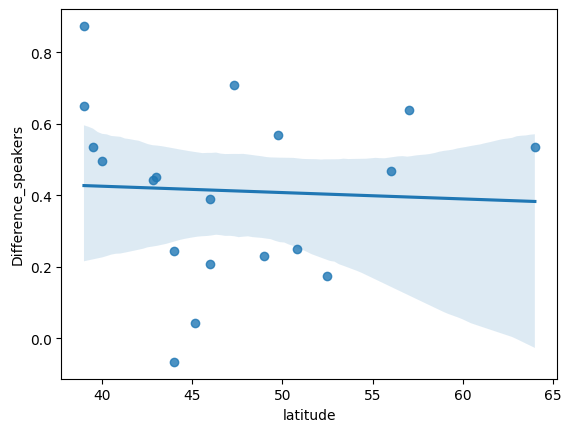

In [5]:
import seaborn as sns
from scipy.stats import pearsonr
sns.regplot(turning,
            x="latitude",
            y="Difference_speakers"
            )
pearsonr(turning.dropna().latitude, turning.dropna().Difference_speakers)


PearsonRResult(statistic=0.2662085933893079, pvalue=0.3017020274135259)

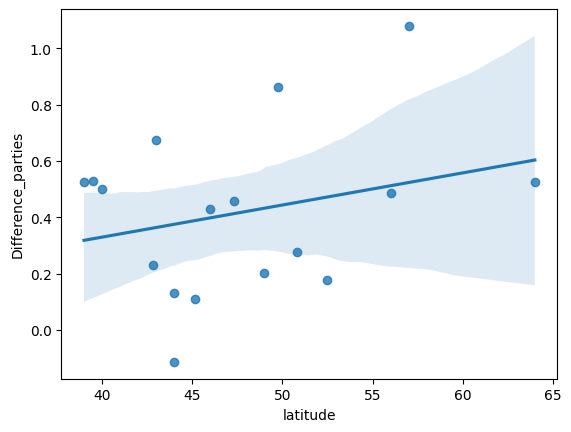

In [6]:
import seaborn as sns
from scipy.stats import pearsonr
sns.regplot(turning,
            x="latitude",
            y="Difference_parties"
            )
pearsonr(turning.dropna().latitude, turning.dropna().Difference_parties)